# Benchmarking Data Normalization Methods with the Dexamethasone Benchmarking Resource (Characteristic Direction Version)

This notebook reads in designated meta data and RNA-seq expression data files from a dexamethasone study and performs several different normalization methods - including counts per million (CPM), log transformation, z-score normalization, and quantile normalization - on the data.

After differential gene analysis and enrichment analysis, the results from each normalization method are compared with known transcription factor targets of dexamethasone and their downstream target genes. 

Some code has been adapted from the [Bulk RNA-seq Analysis Pipeline Appyter](https://appyters.maayanlab.cloud/Bulk_RNA_seq/).

In [59]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from IPython.display import display, Markdown
import json
import requests
import time
from random import sample
from maayanlab_bioinformatics.dge.characteristic_direction import characteristic_direction
from maayanlab_bioinformatics.normalization import quantile, cpm, log, zscore
from maayanlab_bioinformatics.plotting.bridge import bridge_plot
import matplotlib.pyplot as plt

# Load in Data

Using data from GEO from the study ["Gene expression profiling of MDA_MB_231 cell line in response to treatment with Dexamethasone and SH4-54" (GSE137535)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE137535)

In [5]:
# Set all variables
meta_class_column_name = 'Class'
control_name = 'treatment: No Drug'
treatment = 'treatment: DEX'
meta_data_filename = 'GSE137535_series_matrix.txt'
rnaseq_data_filename = 'GSE137535_MB231_DEXwSH454TreamtentsFeatureCountsedited_SH454wDEX.counts.txt'
low_expression_threshold = 0.3

In [17]:
# Load in metadata
try:
    if meta_data_filename.endswith('.csv'): 
        meta_df = pd.read_csv(meta_data_filename, index_col=0)
    else:
        meta_df = pd.read_csv(meta_data_filename, sep="\t", index_col=0)
    print(f"Metadata file shape: {meta_df.shape[0]} samples, {meta_df.shape[1]} features")
except:
    print("Error! Please ensure the metadata file is in CSV, TXT, or TSV format.")

# Load in data
try:
    if rnaseq_data_filename.endswith('.csv'): 
        expr_df = pd.read_csv(rnaseq_data_filename, index_col=0).sort_index()
    else:
        expr_df = pd.read_csv(rnaseq_data_filename, sep="\t", index_col=0).sort_index()
    print(f"RNA-seq data file shape: {expr_df.shape[0]} genes, {expr_df.shape[1]} samples")
except:
    print("Error! Please ensure the RNA-seq file is in CSV, TXT, or TSV format.")

# Match samples between the metadata and the dataset
if meta_class_column_name not in meta_df.columns:
    print(f"Error! Column '{meta_class_column_name}' was not found in the metadata.")

shared_samples = set(meta_df.index).intersection(expr_df.columns)
meta_df = meta_df[meta_df.index.isin(shared_samples)].sort_values(by=['Class'])
expr_df = expr_df[shared_samples]
print(f"\nThe pipeline will be run on {len(shared_samples)} samples.")

Metadata file shape: 6 samples, 1 features
RNA-seq data file shape: 26364 genes, 12 samples

The pipeline will be run on 6 samples.


In [19]:
# Sort metadata by class labels; control first
expr_df = pd.concat([
    expr_df[meta_df[meta_df['Class']==control_name].index],
    expr_df[meta_df[meta_df['Class']!=control_name].index]
], axis=1)

In [20]:
## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 0, :]
## Filter out lowly expressed genes
mask_low_vals = (expr_df > low_expression_threshold).sum(axis=1) > 2
expr_df = expr_df.loc[mask_low_vals, :]
print(f"Number of genes after filtering by low expression: {expr_df.shape[0]}")

# Dictionary to store all normalized datasets
dataset = {'metadata': meta_df, 'rawdata': expr_df}

Number of genes after filtering by low expression: 17685


In [21]:
# Display meta data
dataset['metadata']

,Class
Sample_geo_accession,
GSM4081445,treatment: DEX
GSM4081446,treatment: DEX
GSM4081447,treatment: DEX
GSM4081451,treatment: No Drug
GSM4081452,treatment: No Drug
GSM4081453,treatment: No Drug


In [22]:
# Display expression data
dataset['rawdata']

,GSM4081451,GSM4081452,GSM4081453,GSM4081445,GSM4081446,GSM4081447
Geneid,,,,,,
A1BG,91,92,76,75,80,74
A1BG-AS1,13,10,12,16,21,19
A1CF,3,2,5,1,2,2
A2M-AS1,0,0,0,1,1,1
A2ML1,1,0,2,0,0,2
...,...,...,...,...,...,...
ZYG11A,496,488,429,352,434,327
ZYG11B,3118,2815,2728,2436,2897,2517
ZYX,773,666,579,633,621,582


# Normalization Methods

### CPM Normalization

In [23]:
# Perform CPM normalization
dataset['cpm'] = cpm.cpm_normalize(dataset['rawdata'])
dataset['cpm']

,GSM4081451,GSM4081452,GSM4081453,GSM4081445,GSM4081446,GSM4081447
Geneid,,,,,,
A1BG,2.884170,3.076275,2.672386,2.880211,2.718669,2.764710
A1BG-AS1,0.412024,0.334378,0.421956,0.614445,0.713651,0.709858
A1CF,0.095083,0.066876,0.175815,0.038403,0.067967,0.074722
A2M-AS1,0.000000,0.000000,0.000000,0.038403,0.033983,0.037361
A2ML1,0.031694,0.000000,0.070326,0.000000,0.000000,0.074722
...,...,...,...,...,...,...
ZYG11A,15.720313,16.317635,15.084914,13.517792,14.748782,12.217031
ZYG11B,98.822450,94.127340,95.924580,93.549264,98.449818,94.037510
ZYX,24.499600,22.269559,20.359359,24.308984,21.103672,21.744073


### Log Transformation

In [24]:
# Display log transformation results
dataset['log'] = log.log2_normalize(dataset['rawdata'])
dataset['log']

,GSM4081451,GSM4081452,GSM4081453,GSM4081445,GSM4081446,GSM4081447
Geneid,,,,,,
A1BG,6.523562,6.539159,6.266787,6.247928,6.339850,6.228819
A1BG-AS1,3.807355,3.459432,3.700440,4.087463,4.459432,4.321928
A1CF,2.000000,1.584963,2.584963,1.000000,1.584963,1.584963
A2M-AS1,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
A2ML1,1.000000,0.000000,1.584963,0.000000,0.000000,1.584963
...,...,...,...,...,...,...
ZYG11A,8.957102,8.933691,8.748193,8.463524,8.764872,8.357552
ZYG11B,11.606868,11.459432,11.414157,11.250891,11.500842,11.298063
ZYX,9.596190,9.381543,9.179909,9.308339,9.280771,9.187352


### Z-Score Normalization 


In [25]:
# Perform Z-score normalization and display results
dataset['z'] = zscore.zscore_normalize(dataset['rawdata'].T).T.fillna(0)
dataset['z']

,GSM4081451,GSM4081452,GSM4081453,GSM4081445,GSM4081446,GSM4081447
Geneid,,,,,,
A1BG,1.300828,1.435396,-0.717698,-0.852266,-0.179425,-0.986835
A1BG-AS1,-0.556859,-1.327894,-0.813871,0.214176,1.499235,0.985212
A1CF,0.397360,-0.397360,1.986799,-1.192079,-0.397360,-0.397360
A2M-AS1,-1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000
A2ML1,0.185695,-0.928477,1.299867,-0.928477,-0.928477,1.299867
...,...,...,...,...,...,...
ZYG11A,1.187240,1.060601,0.126639,-1.092261,0.205788,-1.488008
ZYG11B,1.599081,0.275854,-0.104082,-1.379271,0.633955,-1.025537
ZYX,1.991593,0.360722,-0.965313,-0.142257,-0.325158,-0.919588


### Quantile Normalization

In [26]:
# Perform and display quantile normalization results
dataset['quantile'] = quantile.quantile_normalize(dataset['rawdata'])
dataset['quantile']

,GSM4081451,GSM4081452,GSM4081453,GSM4081445,GSM4081446,GSM4081447
Geneid,,,,,,
A1BG,77.909091,86.510417,76.180556,84.858974,81.541667,81.473684
A1BG-AS1,10.974910,9.359848,11.824324,18.295635,21.235632,21.184314
A1CF,2.367379,1.854730,4.832789,1.218622,2.123965,2.250130
A2M-AS1,0.000000,0.023035,0.056763,1.218622,1.056119,1.135578
A2ML1,0.795610,0.023035,1.930006,0.181692,0.063095,2.250130
...,...,...,...,...,...,...
ZYG11A,441.216667,468.357143,440.777778,387.222222,430.777778,351.791667
ZYG11B,2814.166667,2659.833333,2741.055556,2701.250000,2841.000000,2734.333333
ZYX,701.041667,641.833333,594.190476,697.361111,609.976190,617.777778


### Log Transform + Quantile Normalization

In [27]:
dataset['log+quantile'] = quantile.quantile_normalize(dataset['log'])
dataset['log+quantile']

,GSM4081451,GSM4081452,GSM4081453,GSM4081445,GSM4081446,GSM4081447
Geneid,,,,,,
A1BG,6.295506,6.445046,6.263684,6.417357,6.360852,6.359750
A1BG-AS1,3.574682,3.364984,3.672668,4.263593,4.468604,4.465174
A1CF,1.737439,1.491565,2.533610,1.127886,1.626342,1.685130
A2M-AS1,0.000000,0.023035,0.056763,1.127886,1.016936,1.073047
A2ML1,0.795610,0.023035,1.531735,0.181692,0.063095,1.685130
...,...,...,...,...,...,...
ZYG11A,8.785137,8.871426,8.783688,8.597002,8.751001,8.458842
ZYG11B,11.455165,11.373873,11.417403,11.396246,11.468898,11.413788
ZYX,9.452200,9.325327,9.214166,9.444582,9.251936,9.270319


### Log Transform + Quantile Normalization + Z-Score Normalization

In [29]:
dataset['log+quantile+z'] = zscore.zscore_normalize(dataset['log+quantile'].T).T.fillna(0)
dataset['log+quantile+z']

,GSM4081451,GSM4081452,GSM4081453,GSM4081445,GSM4081446,GSM4081447
Geneid,,,,,,
A1BG,-0.974705,1.394325,-1.478845,0.955673,0.060506,0.043046
A1BG-AS1,-0.883549,-1.354272,-0.663592,0.662902,1.123105,1.115406
A1CF,0.087766,-0.493729,1.970723,-1.353836,-0.174980,-0.035944
A2M-AS1,-1.048375,-1.004435,-0.940100,1.103049,0.891415,0.998446
A2ML1,0.120305,-1.010042,1.197324,-0.777912,-0.951431,1.421756
...,...,...,...,...,...,...
ZYG11A,0.559147,1.183413,0.548662,-0.801937,0.312186,-1.801471
ZYG11B,1.052567,-1.444272,-0.107274,-0.757099,1.474387,-0.218309
ZYX,1.363181,-0.011859,-1.216629,1.280625,-0.807277,-0.608040


In [30]:
# Store methods in a list
methods = [
    'rawdata', 'cpm', 'log', 'z', 'quantile', 
    'log+quantile', 'log+quantile+z'
]

# Comparing Methods
### Differential Gene Expression
Signatures for the original dataset and each of the normalized datasets are computed with the characteristic direction method. 

In [31]:
# Function for computing signatures with characteristic direction
def cd_signature(control, treatment, dataset, normalization, meta_class_column_name):
    
    ctrl_ids = dataset["metadata"].loc[dataset["metadata"][meta_class_column_name]==control, :].index.tolist() #control
    case_ids = dataset["metadata"].loc[dataset["metadata"][meta_class_column_name]==treatment,:].index.tolist() #case
    
    signature = characteristic_direction(
        dataset[normalization].loc[:, ctrl_ids], 
        dataset[normalization].loc[:, case_ids], 
        calculate_sig=True
    )
    signature = signature.sort_values("CD-coefficient", ascending=False)
    
    return signature

Note: The step below may take around 2 minutes to run, due to the nature of the characteristic direction algorithm. 

In [32]:
# Get signatures
signatures = {}
for method in methods:
    signature = cd_signature(control_name, treatment, dataset, method, meta_class_column_name)
    signatures[method] = signature

In [36]:
# Display signatures
for i in range(len(methods)):
    display(Markdown(f"{methods[i].capitalize()} dataset"))
    display(signatures[methods[i]])

Rawdata dataset

,CD-coefficient,Significance
Geneid,,
THBS1,0.689277,-0.019615
SERPINE1,0.231106,-0.040095
ANKRD1,0.181946,0.019168
ANXA2,0.116618,0.020615
ACTB,0.112407,0.007227
...,...,...
VIM,-0.070567,-0.011190
PKM,-0.086434,-0.069334
ITGB1,-0.126319,-0.055656


Cpm dataset

,CD-coefficient,Significance
Geneid,,
THBS1,0.689277,-0.007973
SERPINE1,0.231106,-0.013965
ANKRD1,0.181946,0.029616
ANXA2,0.116618,0.032098
ACTB,0.112407,0.010760
...,...,...
VIM,-0.070567,-0.004603
PKM,-0.086434,-0.022971
ITGB1,-0.126319,0.003715


Log dataset

,CD-coefficient,Significance
Geneid,,
ALOX15B,0.106745,-0.013880
IP6K3,0.103203,-0.126339
DPEP1,0.091695,-0.104789
SCNN1G,0.081783,-0.062304
MAP2,0.078188,-0.115009
...,...,...
IL11,-0.056260,-0.126372
CLDN2,-0.057458,-0.081639
ARL14,-0.057478,-0.026147


Z dataset

,CD-coefficient,Significance
Geneid,,
SLCO2A1,0.016959,-0.108516
ENOX1,0.016937,-0.129729
ADGRL3,0.016930,-0.011965
PLD5,0.016922,-0.166639
PDE3A,0.016921,-0.172670
...,...,...
MAPK8IP1,-0.008680,-0.189577
RELT,-0.008681,-0.144121
CD177,-0.008683,-0.069551


Quantile dataset

,CD-coefficient,Significance
Geneid,,
THBS1,0.442893,0.062220
SERPINE1,0.247168,0.106951
EEF1A1,0.201308,0.158085
ANKRD1,0.170097,0.063041
DKK1,0.153518,0.154010
...,...,...
UBB,-0.108894,0.036037
ITGB1,-0.109154,0.169779
HSPA8,-0.126369,0.169333


Log+quantile dataset

,CD-coefficient,Significance
Geneid,,
ALOX15B,0.106626,-0.016041
IP6K3,0.102975,-0.148518
DPEP1,0.091536,-0.119601
SCNN1G,0.081051,-0.080058
MAP2,0.078978,-0.141156
...,...,...
ZNF84,-0.056924,0.001197
ARL14,-0.058163,-0.029667
CLDN2,-0.058204,-0.092099


Log+quantile+z dataset

,CD-coefficient,Significance
Geneid,,
STK39,0.010705,-0.075067
SEPT11,0.010704,-0.110188
ENDOD1,0.010703,-0.161487
MT1X,0.010701,-0.186477
ADAMTS9,0.010700,-0.012142
...,...,...
IER5,-0.010565,-0.198148
SH3RF2,-0.010566,-0.106253
SAE1,-0.010567,-0.116954


### Enrichment Analysis with Enrichr API
This section uses enrichr for enrichment analysis on the signatures to get rankings for NR3C1. Higher rankings (lower numbers) indicate a better method.

In [37]:
# Get gene lists to put into Enrichr
gene_lists = {'up': {}, 'down': {}, 'combined': {}}
for method in methods:
    gene_lists['up'][method] = signatures[method].head(250).index.tolist()
    gene_lists['down'][method] = signatures[method].tail(250).index.tolist()
    gene_lists['combined'][method] = gene_lists['up'][method] + gene_lists['down'][method]

In [49]:
# Function to get Enrichr Results
def Enrichr_API(enrichr_gene_list, library_name, method, direction):

    all_ranks = []
    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []

    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
    genes_str = '\n'.join(enrichr_gene_list)
    description = f'Dex benchmark {method} {direction} genes'
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error uploading gene list')

    list_data = json.loads(response.text)
    time.sleep(0.5)
    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
    response = requests.get(
        ENRICHR_URL + f"?userListId={list_data['userListId']}&backgroundType={library_name}"
    )
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    enrich_data = json.loads(response.text)
    results_df  = pd.DataFrame(enrich_data[library_name])
    all_ranks.append(list(results_df[0]))
    all_terms.append(list(results_df[1]))
    all_pvalues.append(list(results_df[2]))
    all_adjusted_pvalues.append(list(results_df[6]))

    res_dict = {
        'ranks': all_ranks, 
        'terms': all_terms, 
        'pvals': all_pvalues,
        'adjpvals': all_adjusted_pvalues, 
        'shortid': str(list_data['shortId'])
    }

    return res_dict

In [50]:
# Get results
results = {'up': {}, 'down': {}, 'combined': {}}
for direction in results.keys():
    for method in methods:
        results[direction][method] = Enrichr_API(
            gene_lists[direction][method], 'ChEA_2022', method, direction
        )

In [55]:
# Extract dexamethasone target rankings
# Initialize lists for storing target information
ranks = []
targets = ['NR3C1', 'NR0B1', 'NR1I2']

for method in methods: 
    for direction in results.keys():
        for i in range(len(results[direction][method]['ranks'][0])): 
            if any(t in results[direction][method]['terms'][0][i] for t in targets): 
                ranks.append([
                    f"{method}:{direction}",
                    results[direction][method]['terms'][0][i], 
                    results[direction][method]['ranks'][0][i],
                    results[direction][method]['pvals'][0][i]
                ])
full_df = pd.DataFrame(ranks, columns=['Gene_Set', 'Term', 'Rank', 'p-value'])
full_df['Method'] = full_df['Gene_Set'].apply(lambda x: x.split(':')[0])
full_df['Direction'] = full_df['Gene_Set'].apply(lambda x : x.split(':')[1])
full_df['TF'] = full_df['Term'].apply(lambda x: x.split(' ')[0])

In [77]:
up_df = full_df[full_df['Direction']=='up']
down_df = full_df[full_df['Direction']=='down']
combined_df = full_df[full_df['Direction']=='combined']

### Comparing Rankings

Below are tables and graphs with a summary of the rankings results. For each method, the rankings are averaged across the different dexamethasone target terms.

In [57]:
display(Markdown("Mean ranks of Dex target gene terms from ChEA 2022 for up genes from each method."))
display(up_df.groupby(['Method']).mean().sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))
display(Markdown("Mean ranks of Dex target gene terms from ChEA 2022 for down genes from each method."))
display(down_df.groupby(['Method']).mean().sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))
display(Markdown("Mean ranks of Dex target gene terms from ChEA 2022 for combined up and down genes from each method."))
display(combined_df.groupby(['Method']).mean().sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))

Mean ranks of Dex target gene terms from ChEA 2022 for up genes from each method.

,Rank
Method,
z,65.285714
log+quantile,75.571429
log,84.857143
log+quantile+z,123.285714
cpm,132.000000
rawdata,132.000000
quantile,178.250000


Mean ranks of Dex target gene terms from ChEA 2022 for down genes from each method.

,Rank
Method,
log,260.125000
log+quantile,265.625000
log+quantile+z,293.500000
z,295.428571
cpm,411.375000
rawdata,411.375000
quantile,437.000000


Mean ranks of Dex target gene terms from ChEA 2022 for combined up and down genes from each method.

,Rank
Method,
z,85.714286
log+quantile,106.875000
log,112.875000
log+quantile+z,202.500000
quantile,248.375000
cpm,267.125000
rawdata,267.125000


We can also examine the average rankings for each dexamethasone target individually.

In [58]:
# Calculate and sort by mean rank grouping by method and name

up_df_averages_byTF = up_df.groupby(['TF', 'Method']).mean().sort_values(['TF', 'Rank']).drop(['p-value'], axis=1)
display(Markdown("Mean rankings for each Dex target TF, based on enrichment analysis of up genes from each method"))
display(up_df_averages_byTF)

down_df_averages_byTF = down_df.groupby(['TF', 'Method']).mean().sort_values(['TF', 'Rank']).drop(['p-value'], axis=1)
display(Markdown("Mean rankings for each Dex target TF, based on enrichment analysis of down genes from each method"))
display(down_df_averages_byTF)

combined_df_averages_byTF = combined_df.groupby(['TF', 'Method']).mean().sort_values(['TF', 'Rank']).drop(['p-value'], axis=1)
display(Markdown("Mean rankings for each Dex target TF, based on enrichment analysis of combined up and down genes from each method"))
display(combined_df_averages_byTF)

Mean rankings for each Dex target TF, based on enrichment analysis of up genes from each method

Rank
TF    Method                    
NR0B1 quantile        111.000000
      cpm             122.000000
      rawdata         122.000000
      z               328.000000
      log+quantile    407.000000
      log+quantile+z  437.000000
      log             444.000000
NR1I2 log+quantile     53.000000
      z                53.000000
      log              67.000000
      quantile        182.000000
      cpm             199.000000
      rawdata         199.000000
      log+quantile+z  303.000000
NR3C1 log+quantile     13.800000
      z                15.200000
      log              16.600000
      log+quantile+z   24.600000
      cpm             120.600000
      rawdata         120.600000
      quantile        188.833333

Mean rankings for each Dex target TF, based on enrichment analysis of down genes from each method

Rank
TF    Method                    
NR0B1 log             164.000000
      log+quantile    203.000000
      z               323.000000
      log+quantile+z  324.000000
      quantile        335.000000
      cpm             342.000000
      rawdata         342.000000
NR1I2 z               295.000000
      log+quantile+z  466.000000
      cpm             520.000000
      rawdata         520.000000
      log             521.000000
      log+quantile    527.000000
      quantile        586.000000
NR3C1 log+quantile    232.500000
      log             232.666667
      log+quantile+z  259.666667
      z               290.000000
      cpm             404.833333
      rawdata         404.833333
      quantile        429.166667

Mean rankings for each Dex target TF, based on enrichment analysis of combined up and down genes from each method

Rank
TF    Method                    
NR0B1 quantile        167.000000
      cpm             191.000000
      rawdata         191.000000
      log             303.000000
      log+quantile    313.000000
      z               340.000000
      log+quantile+z  382.000000
NR1I2 z                92.000000
      log+quantile    231.000000
      log             262.000000
      cpm             329.000000
      rawdata         329.000000
      quantile        339.000000
      log+quantile+z  387.000000
NR3C1 z                33.600000
      log+quantile     51.833333
      log              56.333333
      log+quantile+z  141.833333
      quantile        246.833333
      cpm             269.500000
      rawdata         269.500000

In [60]:
color_dict = {
    'rawdata': 'crimson',
    'random': 'black',
    'log': '#636EFA',
    'quantile': '#636EFA',
    'cpm': '#636EFA',
    'z': '#636EFA',
    'log+quantile+z': '#636EFA', 
    'log+quantile': '#636EFA'
}

## Random results

As a sanity check, we can bootstrap random results and compare against the results for each of the methods, as even in the case of raw data we would expect to see some prioritization of dexamethasone target genes if the data is correct. 

We can achieve this by randomly sampling 250 and 500 genes, respectively, from all genes in the dataset multiple times, and then performing the same process of ranking the enrichment analysis results for the random gene sets. 

In [69]:
# bootstrap random results
random_arr = []
for i in range(10):
    rand_250 = sample(dataset['rawdata'].index.tolist(), 250)
    rand_500 = sample(dataset['rawdata'].index.tolist(), 500)
    random_arr.append(('random:250', Enrichr_API(rand_250, 'ChEA_2022', 'random', '250')))
    random_arr.append(('random:500', Enrichr_API(rand_500, 'ChEA_2022', 'random', '500')))

rand_ranks = [] 
for res in random_arr: 
    for i in range(len(res[1]['ranks'][0])):
        if any(t in res[1]['terms'][0][i] for t in targets): 
            rand_ranks.append([
                f"{res[0]}", 
                res[1]['terms'][0][i],
                res[1]['ranks'][0][i],
            ])
rand_df = pd.DataFrame(rand_ranks, columns=['Gene_Set', 'Term', 'Rank'])
rand_df['Method'] = 'random'
rand_df['TF'] = rand_df['Term'].apply(lambda x: x.split(' ')[0])

## Boxplots

Using boxplots, we can visualize the average rankings of the dexamethasone target terms that are displayed in the tables above. This provides a clearer sense of which methods appear to be performing better (smaller numerical rank) across all the terms.

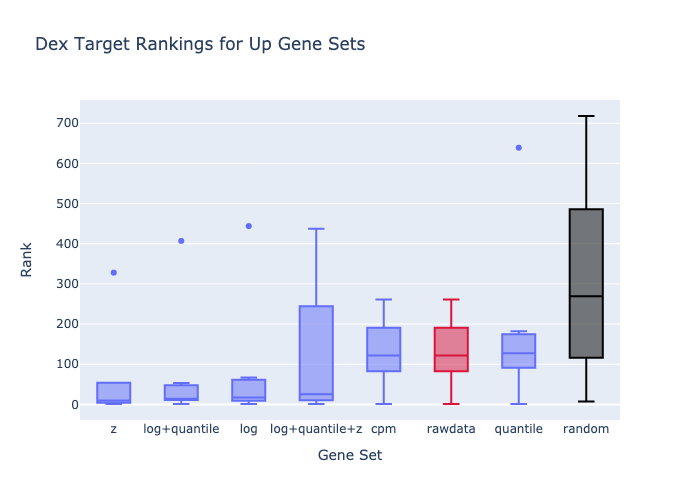

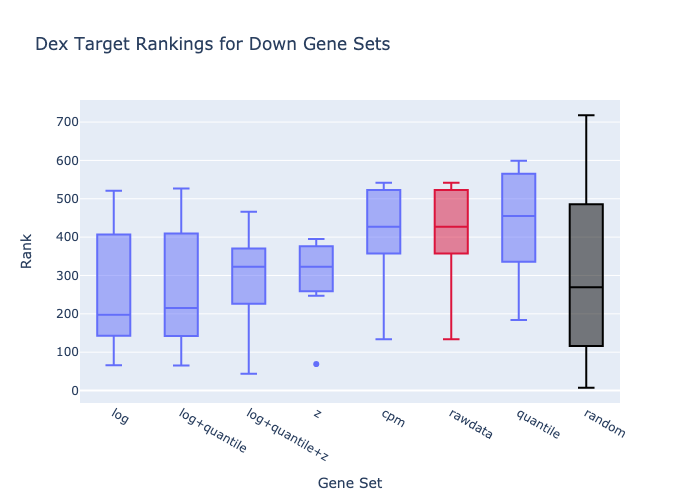

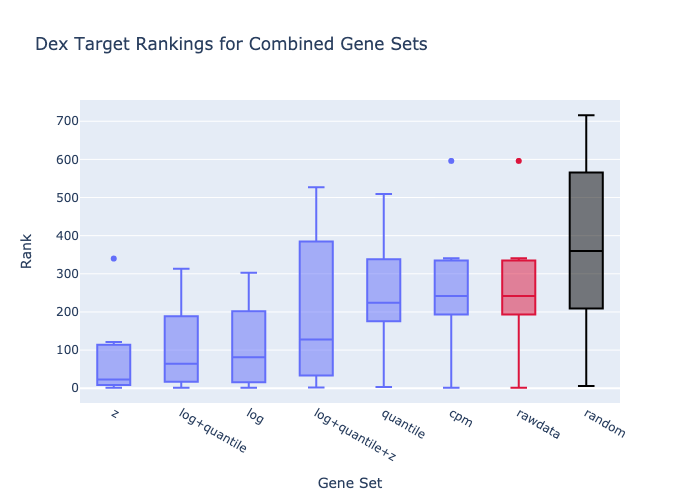

In [186]:
for d in full_df['Direction'].unique(): 
    sub_df = full_df[full_df['Direction']==d]
    if d == 'combined':
        n = '500'
    else:
        n = '250'

    fig1 = go.Figure()
    for gs in sub_df.groupby('Gene_Set').mean().sort_values('Rank').index:
        fig1.add_trace(
            go.Box(
                y=sub_df[sub_df['Gene_Set']==gs]['Rank'].tolist(),
                name=gs.split(':')[0], 
                marker_color=color_dict[gs.split(':')[0]]
            )
        )
    fig1.add_trace(
        go.Box(
            y=rand_df[rand_df['Gene_Set']==f'random:{n}']['Rank'].tolist(),
            name='random',
            marker_color='black'
        )
    )

    fig1.update_layout(
        title_text=f"Dex Target Rankings for {d.capitalize()} Gene Sets",
        xaxis={
            'title': {'text': 'Gene Set'}, 
        },
        yaxis={
            'title': {'text': 'Rank'}
        },
        showlegend=False
    )
    fig1.show("png")

Again, we can break down the results by each target, displaying the rankings of the up/down/combined gene sets for each method corresponding to each target.

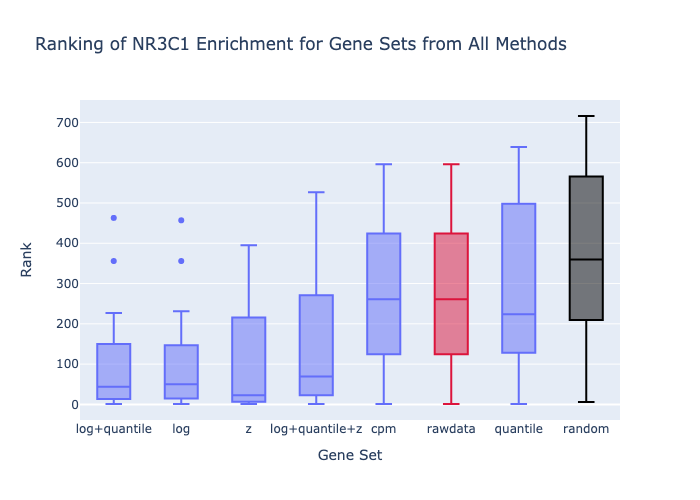

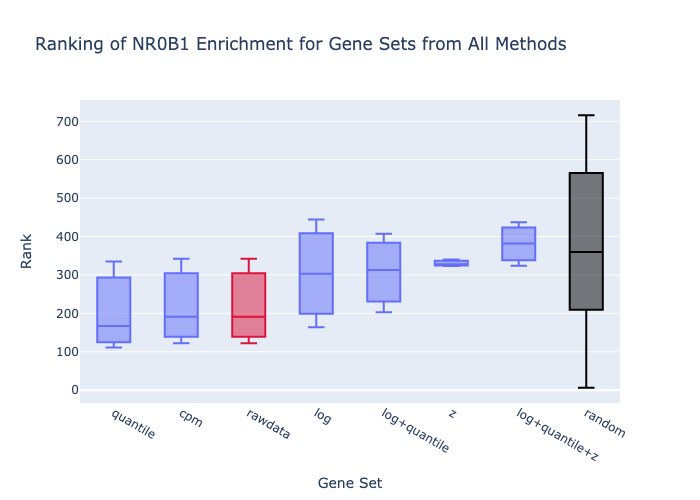

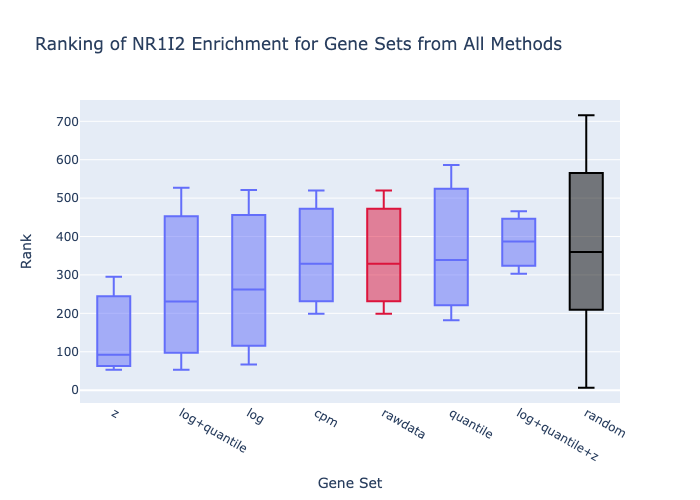

In [90]:
for tf in full_df['TF'].unique(): 
    fig1 = go.Figure()
    sub_df = full_df[full_df['TF'] == tf]
    for m in sub_df.groupby('Method').mean().sort_values('Rank').index:
        fig1.add_trace(
            go.Box(
                y=sub_df[sub_df['Method']==m]['Rank'].tolist(),
                name=m, 
                marker_color=color_dict[m]
            )
        )
    fig1.add_trace(
        go.Box(
            y=rand_df[rand_df['Gene_Set']=='random:500']['Rank'].tolist(),
            name='random',
            marker_color='black'
        )
    )

    fig1.update_layout(
        title_text=f"Ranking of {tf} Enrichment for Gene Sets from All Methods",
        xaxis={
            'title': {'text': 'Gene Set'}, 
        },
        yaxis={
            'title': {'text': 'Rank'}
        },
        showlegend=False
    )
    fig1.show("png")

For a more granular view, we can separate out the up, down and combined gene sets for each transcription factor, which allows us to see patterns across method and direction for each target.

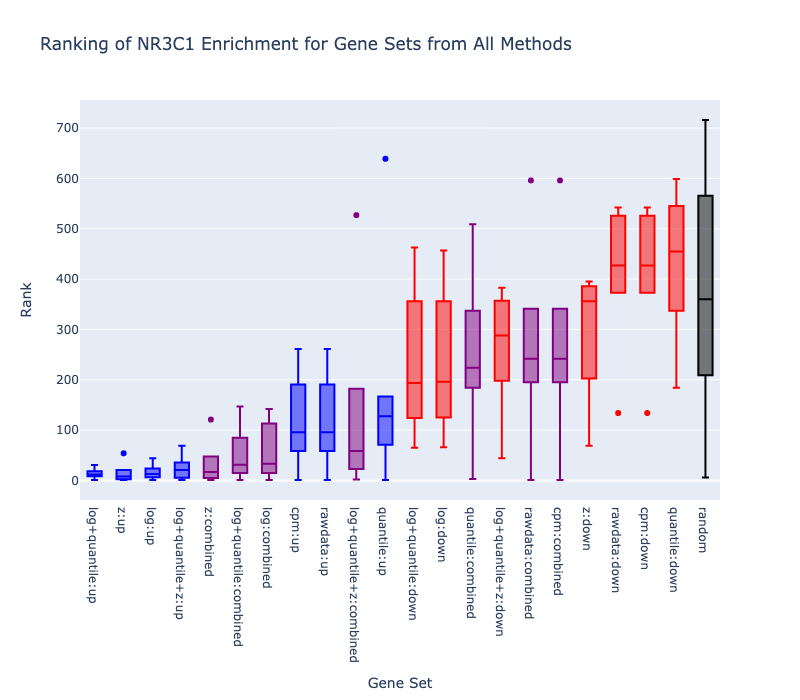

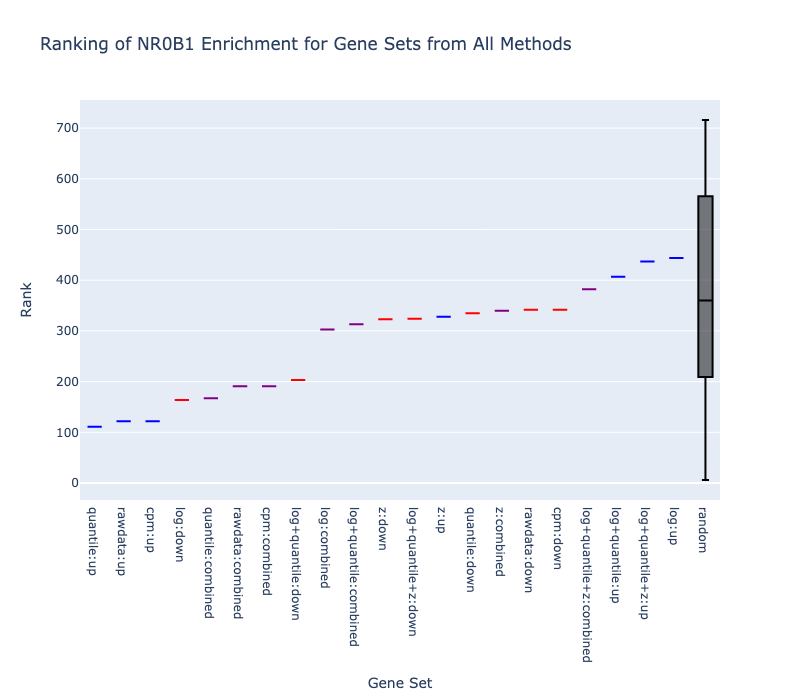

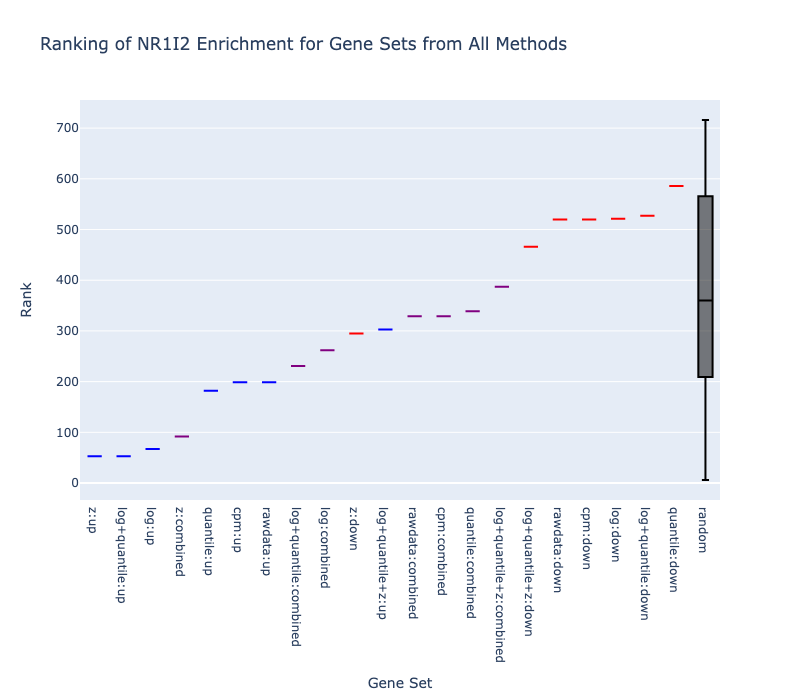

In [95]:
dir_color_map = {
    'up': 'blue', 
    'down': 'red',
    'combined': 'purple'
}

for tf in full_df['TF'].unique(): 
    fig1 = go.Figure()
    sub_df = full_df[full_df['TF'] == tf]
    for gs in sub_df.groupby('Gene_Set').mean().sort_values('Rank').index:
        fig1.add_trace(
            go.Box(
                y=sub_df[sub_df['Gene_Set']==gs]['Rank'].tolist(),
                name=gs, 
                marker_color=dir_color_map[gs.split(':')[1]]
            )
        )
    fig1.add_trace(
        go.Box(
            y=rand_df[rand_df['Gene_Set']=='random:500']['Rank'].tolist(),
            name='random',
            marker_color='black'
        )
    )

    fig1.update_layout(
        title_text=f"Ranking of {tf} Enrichment for Gene Sets from All Methods",
        width=800,
        height=700,
        xaxis={
            'title': {'text': 'Gene Set'}, 
        },
        yaxis={
            'title': {'text': 'Rank'}
        },
        showlegend=False
    )
    fig1.show("png")

In [209]:
def fullBoxplot(color_by_dir=True):
    fig1 = go.Figure()
    for gs in full_df.groupby('Gene_Set').median().sort_values('Rank').index:
        if color_by_dir:
            fig1.add_trace(
                go.Box(
                    y=full_df[full_df['Gene_Set']==gs]['Rank'].tolist(),
                    name=gs, 
                    marker_color=dir_color_map[gs.split(':')[1]]
                )
            )
        else:
            fig1.add_trace(
                go.Box(
                    y=full_df[full_df['Gene_Set']==gs]['Rank'].tolist(),
                    name=gs, 
                    marker_color=color_dict[gs.split(':')[0]]
                )
            )
    fig1.add_trace(
        go.Box(
            y=rand_df[rand_df['Gene_Set']=='random:250']['Rank'].tolist(),
            name='random:250',
            marker_color='black'
        )
    )
    fig1.add_trace(
        go.Box(
            y=rand_df[rand_df['Gene_Set']=='random:500']['Rank'].tolist(),
            name='random:500',
            marker_color='black'
        )
    )

    fig1.update_layout(
        title_text=f"Ranking of Dex Target Enrichment for All Method Gene Sets",
        width=800,
        height=700,
        xaxis={
            'title': {'text': 'Gene Set'}, 
        },
        yaxis={
            'title': {'text': 'Rank'}
        },
        showlegend=False
    )
    fig1.show("png")

Finally, we can look at the average across all transcription factors for each method and direction. The two plots below are colored by the direction of the gene set (up, down or combined) and by the method, respectively.

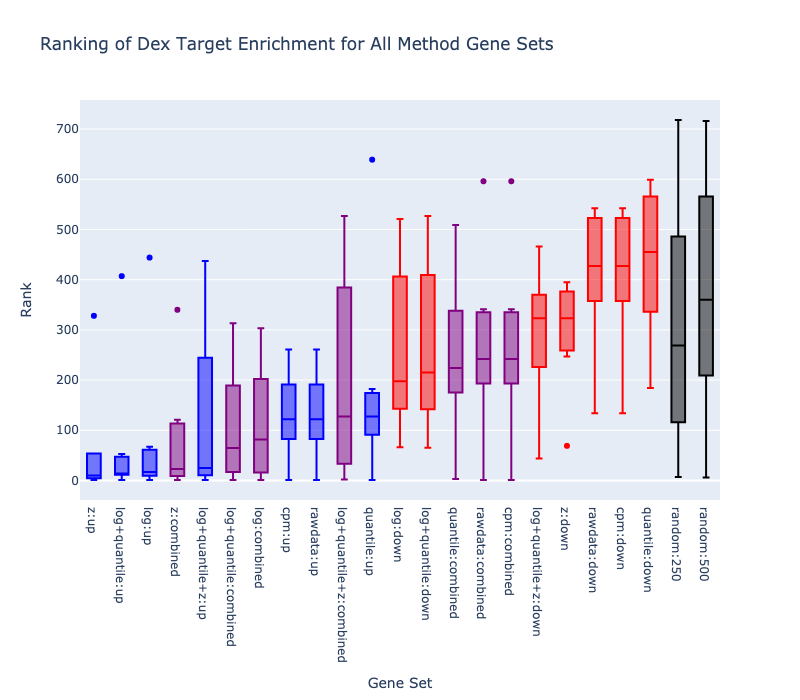

In [210]:
fullBoxplot()

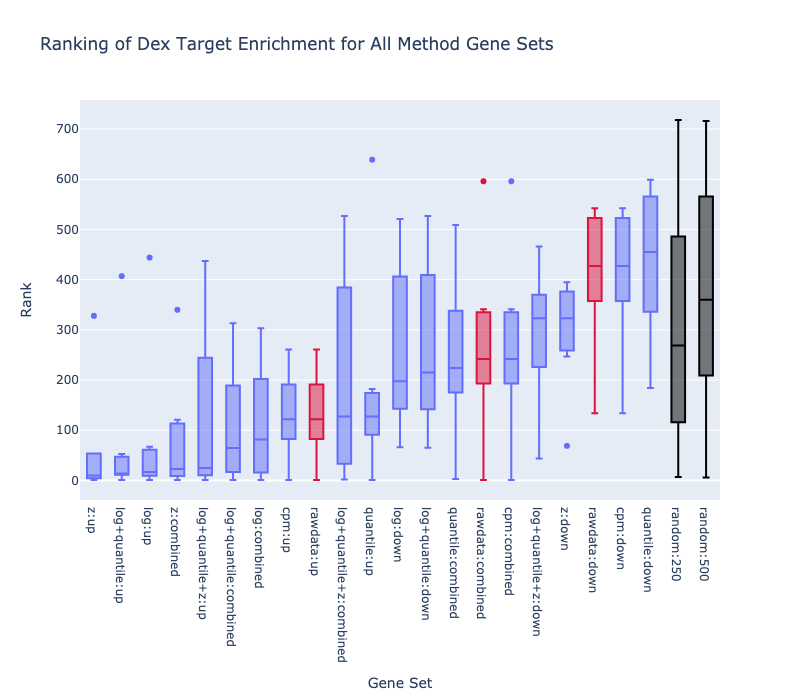

In [211]:
fullBoxplot(color_by_dir=False)

## Bridge plots

The below plots provide the Brownian bridge plots comparing the ranked genes from each method signature with the genes in the target TF gene sets.

In [97]:
def getEnrichrGeneSets(libname, termlist): 
    term_dict = {}
    liburl = f'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=json&libraryName={libname}'
    response = requests.get(liburl)
    if not response.ok:
        raise Exception('Error fetching library from Enrichr')
    for term in termlist:
        geneset = response.json()[libname]['terms'][term].keys()
        term_dict[term] = geneset
    return term_dict

target_genesets = getEnrichrGeneSets('ChEA_2022', full_df['Term'].unique())

In [173]:
def singleBridgePlot(gsname, signame, abs_cd=False):
    geneset = target_genesets[gsname]

    if abs_cd == True:
        abs_vals = signatures[signame]['CD-coefficient'].apply(abs).sort_values(ascending=False)
        select = pd.Series(
            [x.upper() in geneset for x in abs_vals.index.tolist()]
        )
    else:
        select = pd.Series(
            [x.upper() in geneset for x in signatures[signame]['CD-coefficient'].index.tolist()]
        )
    x, y = bridge_plot(select)
    x = x/len(x)
    return x,y

def randomBridgePlot(gsname): 
    all_x = []
    all_y = []

    for _ in range(10):
        rand_sig = sample(
            signatures['rawdata']['CD-coefficient'].index.tolist(), 
            signatures['rawdata']['CD-coefficient'].shape[0]
        )
        select = pd.Series([
            x.upper() in target_genesets[gsname] for x in rand_sig
        ])
        x, y = bridge_plot(select)
        x = x/len(x)
        all_x.append(x)
        all_y.append(y)

    return all_x, all_y

In [174]:
def build_tf_res(abs_cd=False):
    tf_res = {tf: {'random': {'x': [], 'y': []}} for tf in full_df['TF'].unique()}
    for gs in target_genesets.keys():
        tf = gs.split(' ')[0]
        rand_x, rand_y = randomBridgePlot(gs)
        tf_res[tf]['random']['x'] += rand_x
        tf_res[tf]['random']['y'] += rand_y
        for sig in signatures.keys():
            temp_x, temp_y = singleBridgePlot(gs, sig, abs_cd=abs_cd)
            if sig in tf_res[tf].keys():
                tf_res[tf][sig]['x'].append(temp_x)
                tf_res[tf][sig]['y'].append(temp_y)
            else: 
                tf_res[tf][sig] = {'x': [temp_x], 'y': [temp_y]}
    return tf_res

tf_results = build_tf_res(abs_cd=False)
tf_results_abs = build_tf_res(abs_cd=True)

In [182]:
def tfBridgePlot(abs_cd=False):
    if abs_cd:
        tf_res = tf_results_abs
    else: 
        tf_res = tf_results
    for tf in tf_res.keys():
        for sig in tf_res[tf].keys(): 
            tf_x = np.mean(tf_res[tf][sig]['x'], axis=0)
            tf_y = np.mean(tf_res[tf][sig]['y'], axis=0)
            if sig == 'random': 
                plt.plot(tf_x, tf_y, label=sig, color='gray')
            elif sig == 'cpm': 
                plt.plot(tf_x-(0.01*max(tf_x)), tf_y, label=sig)
            else:
                plt.plot(tf_x, tf_y, label=sig)

        plt.axhline(y=0, color='black', linestyle='dashed')
        plt.legend(bbox_to_anchor=(1, 1))
        if abs_cd:
            plt.title(f"{tf} Target Gene Rankings for Each Method (Absolute Value)")
        else:
            plt.title(f"{tf} Target Gene Rankings for Each Method")
        plt.show()

Below are the results for when the genes in each signature are ranked from most positive differential expression to most negative differential expression. Each line represents the average of the target gene terms, if the target had more than one term in the library.

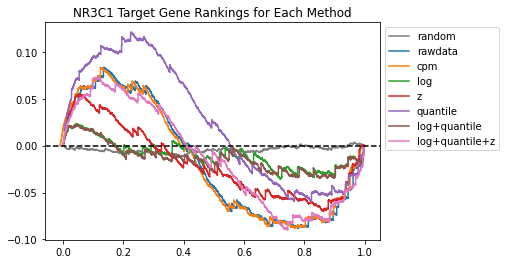

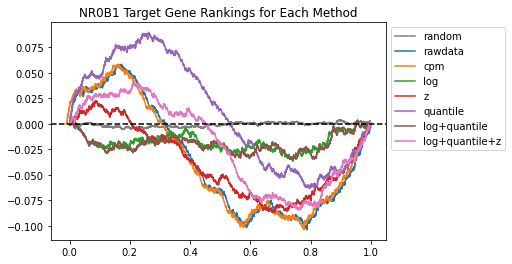

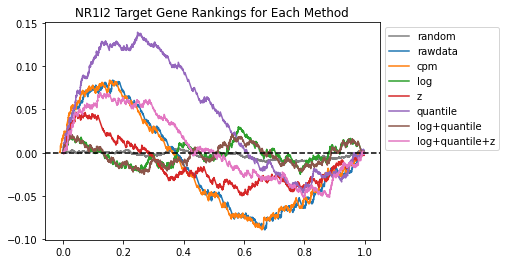

In [183]:
tfBridgePlot()

We can also take the absolute value of the differential expression values before ranking the genes, which allows us to capture genes that are both activated and inhibited towards the earlier ranks. This produces a smoother curve.

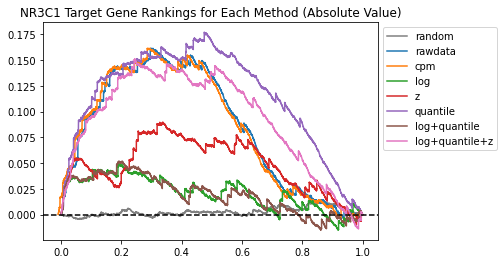

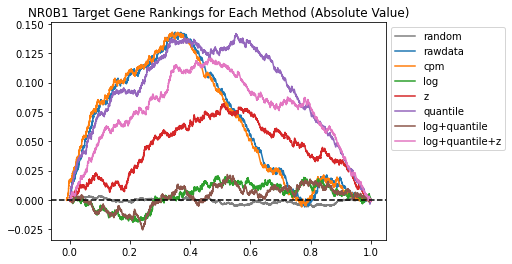

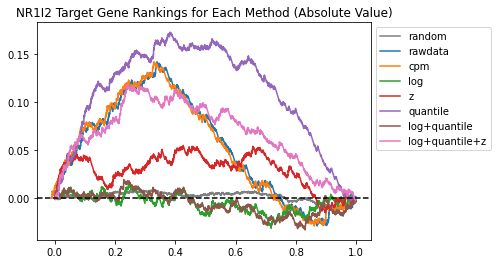

In [184]:
tfBridgePlot(abs_cd=True)

In [214]:
def fullBridgePlot(abs_cd=False):
    if abs_cd:
        tf_res = tf_results_abs
    else: 
        tf_res = tf_results
    for m in methods + ['random']:
        all_x = []
        all_y = []
        for tf in tf_results.keys():
            all_x += tf_res[tf][m]['x']
            all_y += tf_res[tf][m]['y']
        m_x = np.mean(all_x, axis=0)
        m_y = np.mean(all_y, axis=0)
        if m == 'random': 
            plt.plot(m_x, m_y, label=m, color='gray')
        elif m == 'cpm': 
            plt.plot(m_x-(0.01*max(m_x)), m_y, label=m)
        else:
            plt.plot(m_x, m_y, label=m)

    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.legend(bbox_to_anchor=(1, 1))
    if abs_cd:
        plt.title(f"Average Target Gene Rankings for Each Method (Absolute Value)")
    else:
        plt.title(f"Average Target Gene Rankings for Each Method")
    plt.show()

Finally, we can average the plots across all the transcription factor targets and generate plots using both the original differential expression values and the absolute values.

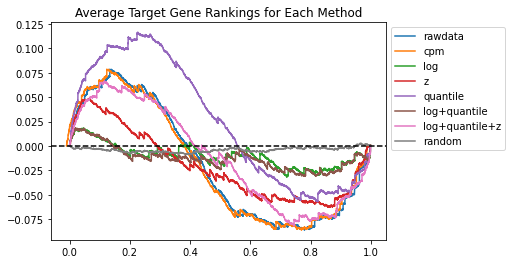

In [215]:
fullBridgePlot()

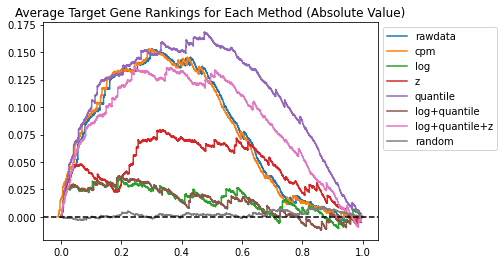

In [216]:
fullBridgePlot(abs_cd=True)